# PITT hurst computation

In [2]:
import os
import pandas as pd
import librosa
import neurokit2 as nk
from tqdm import tqdm

# Global dictionary to store computed results for each file.
results_dict = {}

def process_csv(input_csv, output_csv, file_type):
    # Read the CSV file containing input information.
    df = pd.read_csv(input_csv)
    
    # Determine the set of processed files if the output CSV exists.
    processed_files = set()
    if os.path.exists(output_csv):
        try:
            existing_df = pd.read_csv(output_csv)
            processed_files = set(existing_df["file"].tolist())
            print(f"Resuming {output_csv}. Already processed files: {len(processed_files)}")
        except Exception as e:
            print(f"Warning: Could not read output CSV '{output_csv}': {e}")
    
    # We'll write the header once if the file does not exist.
    header_written = os.path.exists(output_csv)
    
    # Process each row with a tqdm progress bar.
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {file_type} data"):
        file_name = row["file"]
        label = row["label"]
        
        # Remove the first 10 characters from the path
        original_path = row["path"]
        mp3_path = original_path  # Skip first 10 characters
        
        # Skip file if already processed.
        if file_name in processed_files:
            continue

        # Check if the MP3 file exists.
        if not os.path.exists(mp3_path):
            print(f"Warning: File '{mp3_path}' not found. Skipping.")
            continue

        try:
            # Load the MP3 file with resampling to 16kHz.
            signal, _ = librosa.load(mp3_path, sr=16000)
        except Exception as e:
            print(f"Warning: Could not load file '{mp3_path}': {e}")
            continue

        try:
            # Compute fractal Hurst exponent using multiple scales.
            # Here we use scale=[800, 1600] corresponding to 50ms and 100ms windows.
            result = nk.fractal_hurst(signal, scale=[800, 1600])
        except Exception as e:
            print(f"Warning: Could not compute fractal Hurst for file '{mp3_path}': {e}")
            continue

        # Extract values assuming result is a tuple:
        # result[0]: fractal_exponent
        # result[1]: dictionary with keys "Values", "Scores", "Intercept"
        if isinstance(result, tuple) and len(result) > 1 and isinstance(result[1], dict):
            fractal_exponent = result[0]
            result_info = result[1]
            values_array = result_info.get("Values", [])
            scores_array = result_info.get("Scores", [])
            intercept = result_info.get("Intercept", "")
            value_1 = values_array[0] if len(values_array) > 0 else ""
            value_2 = values_array[1] if len(values_array) > 1 else ""
            score_1 = scores_array[0] if len(scores_array) > 0 else ""
            score_2 = scores_array[1] if len(scores_array) > 1 else ""
        else:
            fractal_exponent, value_1, value_2, score_1, score_2, intercept = ("", "", "", "", "", "")

        # Build a row with the desired output columns.
        result_row = {
            "file": file_name,
            "label": label,
            "fractal_exponent": fractal_exponent,
            "value_1": value_1,
            "value_2": value_2,
            "score_1": score_1,
            "score_2": score_2,
            "intercept": intercept
        }

        try:
            # Write header if not already written.
            if not header_written:
                with open(output_csv, "w") as f_out:
                    header = ",".join(result_row.keys())
                    f_out.write(header + "\n")
                header_written = True

            # Append the current row to the CSV.
            with open(output_csv, "a") as f_out:
                row_str = ",".join(str(result_row.get(col, "")) for col in result_row.keys())
                f_out.write(row_str + "\n")
        except Exception as e:
            print(f"Warning: Could not write result for file '{mp3_path}': {e}")
            continue

        # Store the computed result in the global results_dict.
        results_dict[file_name] = result_row

# Process the training and validation data separately
process_csv("D:/OneDrive - Amrita Vishwa Vidyapeetham/Sem-6/Project/SP/pitt_data_files.csv", "D:/OneDrive - Amrita Vishwa Vidyapeetham/Sem-6/Project/SP/total_hurst.csv", "train")

print("Processing complete.")

Processing train data:   0%|          | 0/549 [00:00<?, ?it/s]c:\Users\swaro\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\swaro\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\swaro\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Processing train data: 100%|██████████| 549/549 [01:31<00:00,  6.03it/s]

Processing complete.


In [2]:
!pip install tensorflow torch torchvision torchaudio transformers==4.38.2 librosa pandas scikit-learn xgboost joblib tqdm

  Using cached transformers-4.38.2-py3-none-any.whl.metadata (130 kB)
  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.0.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-

# Embedding Generator using Wav2Vec2

In [ ]:
import os
import pandas as pd
import librosa
from tqdm import tqdm
import torch # PyTorch library
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib # For saving the LabelEncoder

# --- Configuration ---
INPUT_CSV = "pitt_data_files.csv"
WAV2VEC2_MODEL_NAME = "facebook/wav2vec2-base-960h"
TARGET_SAMPLE_RATE = 16000
TRAINED_XGBOOST_OUTPUT_PATH = "trained_wav2vec_xgb_classifier.json"
LABEL_ENCODER_PATH = "label_encoder.joblib"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# --- Load Wav2Vec2 Model (Load once using PyTorch/Transformers) ---
print(f"Loading Wav2Vec2 Processor: {WAV2VEC2_MODEL_NAME}...")
processor = Wav2Vec2Processor.from_pretrained(WAV2VEC2_MODEL_NAME)
print(f"Loading Wav2Vec2 Model: {WAV2VEC2_MODEL_NAME}...")
wav2vec_model = Wav2Vec2Model.from_pretrained(WAV2VEC2_MODEL_NAME) # This is a PyTorch model

# --- Determine device (GPU/CUDA if available, else CPU) ---
# This is the core CUDA detection logic using PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec_model.to(device) # Move the PyTorch model to the selected device (GPU or CPU)
wav2vec_model.eval() # Set PyTorch model to evaluation mode
print(f"Using device: {device}") # Check if it prints 'cuda' or 'cpu'


def extract_embeddings(input_csv, processor, wav2vec_model, device, target_sr):
    """
    Reads an input CSV, loads audio files, extracts Wav2Vec2 embeddings using PyTorch
    (potentially on CUDA device), and returns lists/arrays.
    """
    all_embeddings = []
    all_labels = []
    processed_filenames = []
    failed_files = []

    try:
        df = pd.read_csv(input_csv)
    except FileNotFoundError:
        print(f"Error: Input CSV file not found at '{input_csv}'.")
        return None, None, None, None
    except Exception as e:
        print(f"Error reading input CSV '{input_csv}': {e}.")
        return None, None, None, None

    print(f"Starting embedding extraction from {input_csv}...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Embeddings"):
        if not all(col in row for col in ["file", "label", "path"]):
            print(f"Warning: Skipping row {idx+2} in {input_csv} due to missing columns.")
            failed_files.append(f"Row {idx+2} (Missing Cols)")
            continue

        file_name = row["file"]
        label = row["label"]
        original_path = row["path"]

        if pd.isna(original_path) or len(str(original_path)) <= 11:
             print(f"Warning: Invalid or short path '{original_path}' for file '{file_name}'. Skipping.")
             failed_files.append(file_name)
             continue
        audio_path = str(original_path)[11:]

        if not os.path.exists(audio_path):
            print(f"Warning: File '{audio_path}' not found. Skipping.")
            failed_files.append(file_name)
            continue

        try:
            signal, sr = librosa.load(audio_path, sr=target_sr)
            if signal is None or len(signal) == 0:
                 print(f"Warning: Loaded empty signal for file '{audio_path}'. Skipping.")
                 failed_files.append(file_name)
                 continue

            # Preprocess for PyTorch model, requesting PyTorch tensors ("pt")
            input_values = processor(signal, sampling_rate=target_sr, return_tensors="pt", padding=True).input_values
            # Move input tensor to the selected device (GPU/CUDA or CPU)
            input_values = input_values.to(device)

            # Perform inference using PyTorch (on GPU if available)
            with torch.no_grad(): # PyTorch inference context
                outputs = wav2vec_model(input_values) # Runs on 'device'
                embedding = torch.mean(outputs.last_hidden_state, dim=1).squeeze() # PyTorch tensor operation

            # Store embedding (move back to CPU for NumPy conversion) and label
            all_embeddings.append(embedding.cpu().numpy())
            all_labels.append(label)
            processed_filenames.append(file_name)

        except Exception as e:
            print(f"Warning: Could not process file '{audio_path}': {e}")
            failed_files.append(file_name)
            continue

    print(f"Embedding extraction finished. Processed: {len(processed_filenames)}, Failed: {len(failed_files)}")
    if failed_files:
        print("Failed files/rows:", failed_files)

    if not all_embeddings:
        print("Error: No embeddings were successfully extracted.")
        return None, None, None, None

    embeddings_array = np.array(all_embeddings)
    labels_array = np.array(all_labels)

    return embeddings_array, labels_array, processed_filenames, failed_files


# --- Main Execution ---
if __name__ == "__main__":
    # 1. Extract Embeddings (uses PyTorch, automatically uses CUDA if available)
    embeddings, labels, filenames, failed = extract_embeddings(
        input_csv=INPUT_CSV,
        processor=processor,
        wav2vec_model=wav2vec_model, # This is the PyTorch model
        device=device,             # This is 'cuda' or 'cpu'
        target_sr=TARGET_SAMPLE_RATE
    )

    if embeddings is None or labels is None or len(embeddings) == 0:
        print("Exiting due to issues during embedding extraction.")
        exit()
    if len(embeddings) != len(labels):
         print(f"Mismatch between number of embeddings ({len(embeddings)}) and labels ({len(labels)}). Exiting.")
         exit()

    print(f"Successfully extracted {len(embeddings)} embeddings.")
    print("Shape of embeddings array:", embeddings.shape)

    # 2. Encode Labels (using scikit-learn)
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)
    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
    try:
        joblib.dump(label_encoder, LABEL_ENCODER_PATH)
        print(f"LabelEncoder saved to {LABEL_ENCODER_PATH}")
    except Exception as e:
        print(f"Warning: Could not save LabelEncoder: {e}")

    # 3. Split Data (using scikit-learn)
    print(f"Splitting data into training and validation sets (Test Size: {TEST_SIZE})...")
    X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
        embeddings, numerical_labels, filenames,
        test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=numerical_labels
    )
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")

    # 4. Train XGBoost Model (XGBoost runs on CPU)
    print("Training XGBoost model...")
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax', num_class=len(label_encoder.classes_),
        eval_metric=['mlogloss', 'merror'], use_label_encoder=False,
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )
    eval_set = [(X_train, y_train), (X_val, y_val)]
    xgb_classifier.fit(
        X_train, y_train, eval_set=eval_set, verbose=True, early_stopping_rounds=20
    )
    print("XGBoost model training complete.")

    # 5. Evaluate Model (using scikit-learn)
    print("\n--- Validation Set Evaluation ---")
    y_pred_val = xgb_classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\nValidation Classification Report:")
    try:
        print(classification_report(label_encoder.inverse_transform(y_val),
                                    label_encoder.inverse_transform(y_pred_val),
                                    target_names=label_encoder.classes_))
    except ValueError as ve:
         print(f"Could not generate full classification report: {ve}")
         print(classification_report(y_val, y_pred_val))

    # 6. Save the Trained XGBoost Model
    print(f"\nSaving trained XGBoost model to {TRAINED_XGBOOST_OUTPUT_PATH}...")
    try:
        xgb_classifier.save_model(TRAINED_XGBOOST_OUTPUT_PATH)
        print("Model saved successfully.")
    except Exception as e:
        print(f"Error saving XGBoost model: {e}")

    print("\nProcess finished.")

In [5]:
import numpy as np
import joblib

# Suppose these live in RAM right now:
# embeddings: np.ndarray of shape (N, D)
# labels:    np.ndarray or list of length N
# filenames: list of length N (optional)

# 1. Save embeddings (compressed)
np.savez_compressed("embeddings.npz", embeddings=embeddings)
print("→ embeddings.npz written")

# 2. Save labels
np.save("labels.npy", labels)
print("→ labels.npy written")

# 3. (Optional) Save filenames
joblib.dump(filenames, "filenames.joblib")
print("→ filenames.joblib written")

→ embeddings.npz written
→ labels.npy written
→ filenames.joblib written


# XGBoost with just the embeddings

In [6]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# --- Paths to your saved data ---
EMBEDDINGS_PATH = "embeddings.npz"
LABELS_PATH     = "labels.npy"
FILENAMES_PATH  = "filenames.joblib"  # optional

# --- Load embeddings and labels ---
data = np.load(EMBEDDINGS_PATH)
embeddings = data["embeddings"]         # shape (N, D)
labels_raw = np.load(LABELS_PATH)       # shape (N,)
try:
    filenames = joblib.load(FILENAMES_PATH)
except:
    filenames = None

# --- Encode labels (if they’re strings) ---
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_raw)
print("Label mapping:", dict(zip(label_encoder.classes_,
                                label_encoder.transform(label_encoder.classes_))))

# --- Split into train / validation ---
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")

# --- Train XGBoost (no early stopping) ---
num_classes = len(label_encoder.classes_)
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='merror',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train, y_train)
print("Training complete.")

# --- Evaluate on validation set ---
y_pred = xgb_clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"\nValidation Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(
    label_encoder.inverse_transform(y_val),
    label_encoder.inverse_transform(y_pred),
    target_names=label_encoder.classes_
))


Label mapping: {np.str_('dementia'): np.int64(0), np.str_('nodementia'): np.int64(1)}
Train size: 439, Val size: 110


c:\Users\Rohit VP\Documents\JUST STUFF\Sem6\Speech Processing\Project\New Data\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

Validation Accuracy: 0.6818

Classification Report:
              precision    recall  f1-score   support

    dementia       0.68      0.80      0.74        61
  nodementia       0.68      0.53      0.60        49

    accuracy                           0.68       110
   macro avg       0.68      0.67      0.67       110
weighted avg       0.68      0.68      0.67       110



# Multiple ML models trained and tested for expermentation

In [1]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")

# --- 1. Load data ---
data = np.load("embeddings.npz")
X = data["embeddings"]            # (N, D)
y_raw = np.load("labels.npy")     # (N,)
filenames = joblib.load("filenames.joblib") if True else None

# --- 2. Encode labels & train/test split ---
le = LabelEncoder()
y = le.fit_transform(y_raw)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. (Optional) feature scaling for models that need it ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- 4. Define your models ---
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest":       RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN":                KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)":          SVC(kernel="rbf", probability=True, random_state=42),
    "XGBoost":            XGBClassifier(
                             objective="multi:softmax",
                             num_class=len(le.classes_),
                             eval_metric="merror",
                             use_label_encoder=False,
                             n_estimators=200,
                             random_state=42
                         ),
}

# --- 5. Train & evaluate each ---
results = {}
for name, model in models.items():
    print(f"\n>>> Training {name}...")
    # pick scaled vs. unscaled features
    X_tr, X_vl = (X_train_scaled, X_val_scaled) if name in ["LogisticRegression","KNN","SVM (RBF)"] else (X_train, X_val)
    model.fit(X_tr, y_train)
    preds = model.predict(X_vl)
    acc = accuracy_score(y_val, preds)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    print(classification_report(
        le.inverse_transform(y_val),
        le.inverse_transform(preds),
        target_names=le.classes_
    ))
    results[name] = acc

# --- 6. Summary ---
print("\n=== Summary of Validation Accuracies ===")
for name, acc in results.items():
    print(f"{name:20s}: {acc:.4f}")



>>> Training LogisticRegression...
LogisticRegression Validation Accuracy: 0.6545
              precision    recall  f1-score   support

    dementia       0.67      0.75      0.71        61
  nodementia       0.63      0.53      0.58        49

    accuracy                           0.65       110
   macro avg       0.65      0.64      0.64       110
weighted avg       0.65      0.65      0.65       110


>>> Training RandomForest...
RandomForest Validation Accuracy: 0.7091
              precision    recall  f1-score   support

    dementia       0.70      0.82      0.76        61
  nodementia       0.72      0.57      0.64        49

    accuracy                           0.71       110
   macro avg       0.71      0.70      0.70       110
weighted avg       0.71      0.71      0.70       110


>>> Training KNN...
KNN Validation Accuracy: 0.6364
              precision    recall  f1-score   support

    dementia       0.66      0.72      0.69        61
  nodementia       0.60      0

# Ensemble Model with embeddings only

In [12]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Load data ---
data = np.load("embeddings.npz")
X = data["embeddings"]          # (N, D)
y_raw = np.load("labels.npy")   # (N,)

# --- 2. Encode labels & split ---
le = LabelEncoder()
y = le.fit_transform(y_raw)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Scale features for SVM ---
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --- 4. Define base models ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
svm = SVC(kernel="rbf", probability=True, random_state=42)
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_),
    eval_metric="merror",
    use_label_encoder=False,
    n_estimators=200,
    random_state=42
)

# --- 5. Build a VotingClassifier ensemble ---
ensemble = VotingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", svm),
        ("xgb", xgb),
    ],
    voting="soft",            # average predicted probabilities
    weights=[1, 1, 1],        # equal weight; tweak if desired
    n_jobs=-1
)

# --- 6. Train ensemble ---
# Note: SVM needs scaled inputs; RF and XGB can use unscaled,
# so we wrap them with pipelines to apply scaling only for SVM.
from sklearn.pipeline import make_pipeline

ensemble = VotingClassifier(
    estimators=[
        ("rf", rf),
        ("svm", make_pipeline(StandardScaler(), svm)),
        ("xgb", xgb),
    ],
    voting="soft",
    weights=[1, 1, 1],
    n_jobs=-1
)

print("Training ensemble...")
ensemble.fit(X_train, y_train)
print("Done.")

# --- 7. Evaluate ---
y_pred = ensemble.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"\nEnsemble Validation Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(
    le.inverse_transform(y_val),
    le.inverse_transform(y_pred),
    target_names=le.classes_
))


Training ensemble...
Done.

Ensemble Validation Accuracy: 0.7273

Classification Report:
              precision    recall  f1-score   support

    dementia       0.73      0.80      0.77        61
  nodementia       0.72      0.63      0.67        49

    accuracy                           0.73       110
   macro avg       0.73      0.72      0.72       110
weighted avg       0.73      0.73      0.72       110



# Deep neural network with embeddings only

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. Load data ---
data = np.load("embeddings.npz")
X = data["embeddings"]          # shape: (N, D)
y_raw = np.load("labels.npy")   # shape: (N,)

# --- 2. Encode labels ---
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# --- 3. Scale features ---
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# --- 4. Reshape data for sequence input ---
# If your embeddings aren't sequential, we add a time-step dimension of 1.
X_seq = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# --- 5. Define a function to create the GRU model ---
def create_model(input_dim, num_classes):
    model = Sequential()
    # First Bidirectional GRU layer returns sequences
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(1, input_dim)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    # Second Bidirectional GRU layer
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    # Dense layers for further processing
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- 6. 10-Fold Cross Validation ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_index, test_index) in enumerate(skf.split(X_seq, y), 1):
    print(f"Training fold {fold}...")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]
    
    model = create_model(X_seq.shape[2], num_classes)
    # Train the model (adjust epochs and batch_size as needed)
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
    
    # Evaluate on the test fold
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    fold_accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

print("\n10-Fold Cross Validation Accuracies:")
for i, acc in enumerate(fold_accuracies, 1):
    print(f"Fold {i}: {acc:.4f}")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")


Training fold 1...
Fold 1 Accuracy: 0.7455
Training fold 2...
Fold 2 Accuracy: 0.6364
Training fold 3...
Fold 3 Accuracy: 0.6909
Training fold 4...
Fold 4 Accuracy: 0.6364
Training fold 5...
Fold 5 Accuracy: 0.8182
Training fold 6...
Fold 6 Accuracy: 0.5636
Training fold 7...
Fold 7 Accuracy: 0.6909
Training fold 8...
Fold 8 Accuracy: 0.8182
Training fold 9...
Fold 9 Accuracy: 0.7273
Training fold 10...
Fold 10 Accuracy: 0.5741

10-Fold Cross Validation Accuracies:
Fold 1: 0.7455
Fold 2: 0.6364
Fold 3: 0.6909
Fold 4: 0.6364
Fold 5: 0.8182
Fold 6: 0.5636
Fold 7: 0.6909
Fold 8: 0.8182
Fold 9: 0.7273
Fold 10: 0.5741
Mean Accuracy: 0.6901


# Merging the embeddings and the previous non linear features

In [3]:
import numpy as np
import pandas as pd
import joblib
import os

# 1. Load embeddings correctly
folder_path = "D:/Dataset/PITT"
npzfile    = np.load(os.path.join(folder_path, "embeddings.npz"))
# if you saved with np.savez(..., embeddings=your_array) then:
# embeddings = npzfile['embeddings']
# otherwise, if you did np.savez("embeddings.npz", your_array), then:
embeddings = npzfile['embeddings']

labels    = np.load(os.path.join(folder_path, "labels.npy"))
filenames = joblib.load(os.path.join(folder_path, "filenames.joblib"))  # length should be same as embeddings.shape[0]

# 2. Build embedding DataFrame
embedding_df = pd.DataFrame(embeddings)
embedding_df['file'] = filenames

# 3. Load your external features
features_train = pd.read_csv(os.path.join(folder_path, "merged_train_features.csv"))
features_valid = pd.read_csv(os.path.join(folder_path, "merged_valid_features.csv"))

# 4. Merge train and valid separately (usually you train/validate separately)
train_df = pd.merge(features_train, embedding_df, on='file', how='inner')
valid_df = pd.merge(features_valid, embedding_df, on='file', how='inner')

# 5. Split out X/y
X_train = train_df.drop(columns=['file','label'])
y_train = train_df['label']

X_valid = valid_df.drop(columns=['file','label'])
y_valid = valid_df['label']
print("Train:", X_train.shape, "Samples:", len(y_train))
print("Valid:", X_valid.shape, "Samples:", len(y_valid))

Train: (435, 790) Samples: 435
Valid: (110, 790) Samples: 110


In [16]:
print(y_valid.head())

0      dementia
1    nodementia
2    nodementia
3      dementia
4      dementia
Name: label, dtype: object


# Training an ensemble method with both the embeddings and the non linear time features

In [21]:
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Load embeddings & handcrafted features ---
# Embeddings
npz   = np.load("embeddings.npz")
X_emb = npz.get("embeddings", npz.get("arr_0"))  # shape (N, D)
files = joblib.load("filenames.joblib")          # length N

# Handcrafted features
df_train_feat = pd.read_csv("../Pitt/merged_train_features.csv")
df_valid_feat = pd.read_csv("../Pitt/merged_valid_features.csv")

# Build embedding DataFrame
n_emb = X_emb.shape[1]
emb_cols = [f"emb_{i}" for i in range(n_emb)]
df_emb = pd.DataFrame(X_emb, columns=emb_cols)
df_emb["file"] = files

# Merge train & valid (we’ll combine then split)
df_all = pd.concat([df_train_feat, df_valid_feat], ignore_index=True)
df_all = df_all.merge(df_emb, on="file", how="inner")

# Drop ‘file’ column
df_all.drop(columns=["file"], inplace=True)

# --- 2. Split out X, y and encode labels ---
X = df_all.drop(columns=["label"]).values
y_raw = df_all["label"].values

le = LabelEncoder()
y = le.fit_transform(y_raw)

# --- 3. Train/validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Define base learners ---
rf  = RandomForestClassifier(n_estimators=200, random_state=42)
svm = SVC(kernel="rbf", probability=True, random_state=42)
xgb = XGBClassifier(
    objective="multi:softprob",        # softprob for probability outputs
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=200,
    random_state=42
)

# --- 5. Build VotingClassifier ensemble ---
ensemble = VotingClassifier(
    estimators=[
        ("rf",  rf),
        # wrap SVM with scaling
        ("svm", make_pipeline(StandardScaler(), svm)),
        ("xgb", xgb),
    ],
    voting="soft",    # average predicted probabilities
    weights=[1, 1, 1],
    n_jobs=-1
)

# --- 6. Train ---
print("Training ensemble...")
ensemble.fit(X_train, y_train)
print("Training complete.")

# --- 7. Evaluate ---
y_pred = ensemble.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"\nEnsemble Validation Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(
    le.inverse_transform(y_val),
    le.inverse_transform(y_pred),
    target_names=le.classes_
))


Training ensemble...
Training complete.

Ensemble Validation Accuracy: 0.8091

Classification Report:
              precision    recall  f1-score   support

    dementia       0.86      0.79      0.82        61
  nodementia       0.76      0.84      0.80        49

    accuracy                           0.81       110
   macro avg       0.81      0.81      0.81       110
weighted avg       0.81      0.81      0.81       110



In [2]:
import numpy as np
import pandas as pd
import joblib
import os

# 1. Load embeddings correctly
folder_path = "D:/Dataset/Dementianet"
npzfile    = np.load(os.path.join(folder_path, "embeddings.npz"))
# if you saved with np.savez(..., embeddings=your_array) then:
# embeddings = npzfile['embeddings']
# otherwise, if you did np.savez("embeddings.npz", your_array), then:
embeddings = npzfile['embeddings']

labels    = np.load(os.path.join(folder_path, "labels.npy"))
filenames = joblib.load(os.path.join(folder_path, "filenames.joblib"))  # length should be same as embeddings.shape[0]

# 2. Build embedding DataFrame
embedding_df = pd.DataFrame(embeddings)
embedding_df['file'] = filenames

# 3. Load your external features
features_train = pd.read_csv(os.path.join(folder_path, "total_train.csv"))
features_valid = pd.read_csv(os.path.join(folder_path, "total_valid.csv"))

# 4. Merge train and valid separately (usually you train/validate separately)
train_df = pd.merge(features_train, embedding_df, on='file', how='inner')
valid_df = pd.merge(features_valid, embedding_df, on='file', how='inner')

# 5. Split out X/y
X_train = train_df.drop(columns=['file','label'])
y_train = train_df['label']

X_valid = valid_df.drop(columns=['file','label'])
y_valid = valid_df['label']

print("Train:", X_train.shape, "labels:", len(y_train))
print("Valid:", X_valid.shape, "labels:", len(y_valid))

Train: (227, 790) labels: 227
Valid: (48, 790) labels: 48


In [10]:
import numpy as np
import pandas as pd
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Load embeddings & handcrafted features ---
# Embeddings
folder_path = "D:/Dataset/Dementianet"
npz   = np.load(os.path.join(folder_path, "embeddings.npz"))
X_emb = npz.get("embeddings", npz.get("arr_0"))  # shape (N, D)
files = joblib.load(os.path.join(folder_path, "filenames.joblib"))          # length N

# Handcrafted features
df_train_feat = pd.read_csv(os.path.join(folder_path, "total_train.csv"))
df_valid_feat = pd.read_csv(os.path.join(folder_path, "total_valid.csv"))

# Build embedding DataFrame
n_emb = X_emb.shape[1]
emb_cols = [f"emb_{i}" for i in range(n_emb)]
df_emb = pd.DataFrame(X_emb, columns=emb_cols)
df_emb["file"] = files

# Merge train & valid (we’ll combine then split)
df_all = pd.concat([df_train_feat, df_valid_feat], ignore_index=True)
df_all = df_all.merge(df_emb, on="file", how="inner")

# Drop ‘file’ column
df_all.drop(columns=["file"], inplace=True)

# Drop any rows with NaN values
df_all.dropna(inplace=True)
# Check if any rows were dropped
if df_all.shape[0] < len(df_train_feat) + len(df_valid_feat):
    print(f"Warning: Some rows were dropped due to NaN values. Remaining rows: {df_all.shape[0]}")

# --- 2. Split out X, y and encode labels ---
X = df_all.drop(columns=["label"]).values
y_raw = df_all["label"].values

le = LabelEncoder()
y = le.fit_transform(y_raw)

# --- 3. Train/validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Define base learners ---
rf  = RandomForestClassifier(n_estimators=200, random_state=42)
svm = SVC(kernel="rbf", probability=True, random_state=42)
xgb = XGBClassifier(
    objective="multi:softprob",        # softprob for probability outputs
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=200,
    random_state=42
)

# --- 5. Build VotingClassifier ensemble ---
ensemble = VotingClassifier(
    estimators=[
        ("rf",  rf),
        # wrap SVM with scaling
        ("svm", make_pipeline(StandardScaler(), svm)),
        ("xgb", xgb),
    ],
    voting="soft",    # average predicted probabilities
    weights=[1, 1, 1],
    n_jobs=-1
)

# --- 6. Train ---
print("Training ensemble...")
ensemble.fit(X_train, y_train)
print("Training complete.")

# --- 7. Evaluate ---
y_pred = ensemble.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"\nEnsemble Validation Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(
    le.inverse_transform(y_val),
    le.inverse_transform(y_pred),
    target_names=le.classes_
))


Training ensemble...
Training complete.

Ensemble Validation Accuracy: 0.5472

Classification Report:
              precision    recall  f1-score   support

    dementia       0.52      0.48      0.50        25
  nodementia       0.57      0.61      0.59        28

    accuracy                           0.55        53
   macro avg       0.54      0.54      0.54        53
weighted avg       0.55      0.55      0.55        53



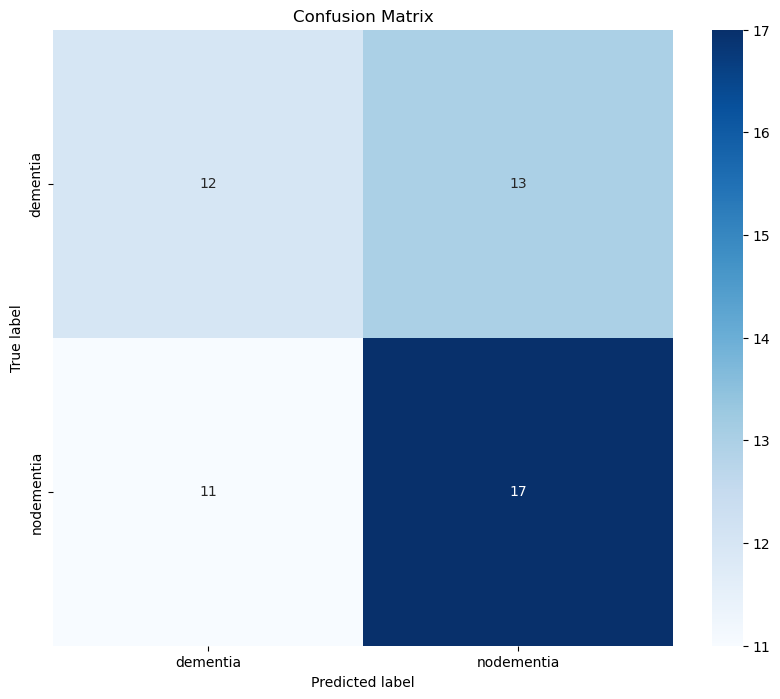

In [11]:
#Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

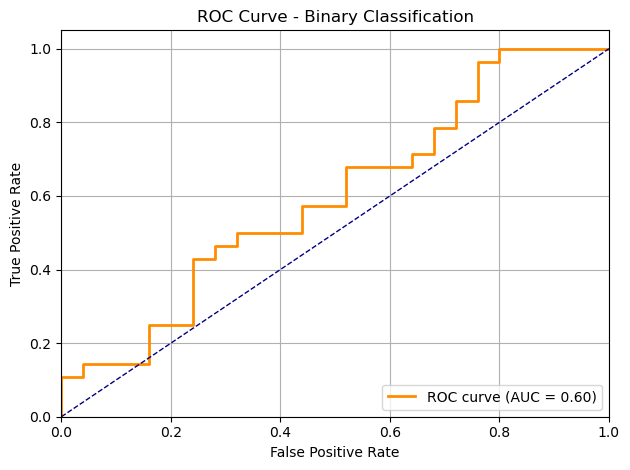

In [12]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# --- 8. ROC Curve for Multi-Class ---
# Binarize the output (for One-vs-Rest ROC curve)
y_val_bin = label_binarize(y_val, classes=range(len(le.classes_)))
y_score = ensemble.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(le.classes_)

fpr, tpr, _ = roc_curve(y_val, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
# --- 1. Load embeddings & handcrafted features ---
# Embeddings
folder_path = "D:/Dataset/Dementianet"
npz   = np.load(os.path.join(folder_path, "embeddings.npz"))
X_emb = npz.get("embeddings", npz.get("arr_0"))  # shape (N, D)
files = joblib.load(os.path.join(folder_path, "filenames.joblib"))          # length N

# Handcrafted features
df_train_feat = pd.read_csv(os.path.join(folder_path, "total_train.csv"))
df_valid_feat = pd.read_csv(os.path.join(folder_path, "total_valid.csv"))

# Build embedding DataFrame
n_emb = X_emb.shape[1]
emb_cols = [f"emb_{i}" for i in range(n_emb)]
df_emb = pd.DataFrame(X_emb, columns=emb_cols)
df_emb["file"] = files

# Merge train & valid (we’ll combine then split)
df_all = pd.concat([df_train_feat, df_valid_feat], ignore_index=True)
print(df_all.shape)
df_all = df_all.merge(df_emb, on="file", how="inner")

# Drop ‘file’ column
df_all.drop(columns=["file"], inplace=True)

# Drop any rows with NaN values
df_all.dropna(inplace=True)
# Check if any rows were dropped
if df_all.shape[0] < len(df_train_feat) + len(df_valid_feat):
    print(f"Warning: Some rows were dropped due to NaN values. Remaining rows: {df_all.shape[0]}")
print(df_all.shape)
print(df_emb.shape)

(275, 24)
(265, 791)
(275, 769)


In [8]:

folder_path_1 = "D:/Dataset/PITT"

npz_1   = np.load(os.path.join(folder_path_1, "embeddings.npz"))
X_emb_1 = npz_1.get("embeddings", npz_1.get("arr_0"))  # shape (N, D)
files_1 = joblib.load(os.path.join(folder_path_1, "filenames.joblib"))          # length N

# Handcrafted features
df_train_feat_1 = pd.read_csv(os.path.join(folder_path_1, "merged_train_features.csv"))
df_valid_feat_1 = pd.read_csv(os.path.join(folder_path_1, "merged_valid_features.csv"))

# Build embedding DataFrame
n_emb_1 = X_emb_1.shape[1]
emb_cols_1 = [f"emb_{i}" for i in range(n_emb_1)]
df_emb_1 = pd.DataFrame(X_emb_1, columns=emb_cols_1)
df_emb_1["file"] = files_1

# Merge train & valid (we’ll combine then split)
df_all_1 = pd.concat([df_train_feat_1, df_valid_feat_1], ignore_index=True)
df_all_1 = df_all_1.merge(df_emb_1, on="file", how="inner")

# Drop ‘file’ column
df_all_1.drop(columns=["file"], inplace=True)

# Drop any rows with NaN values
df_all_1.dropna(inplace=True)
# Check if any rows were dropped
if df_all_1.shape[0] < len(df_train_feat_1) + len(df_valid_feat_1):
    print(f"Warning: Some rows were dropped due to NaN values. Remaining rows: {df_all_1.shape[0]}")
df_all_1.shape

(545, 791)

In [17]:
df_all = pd.concat([df_all, df_all_1], ignore_index=True)
df_all.shape

(810, 791)

In [9]:
df_all = df_all_1
df_all.shape

(545, 791)

In [11]:

# --- 2. Split out X, y and encode labels ---
X = df_all.drop(columns=["label"]).values
y_raw = df_all["label"].values

le = LabelEncoder()
y = le.fit_transform(y_raw)

# --- 3. Train/validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Define base learners ---
rf  = RandomForestClassifier(n_estimators=200, random_state=42)
svm = SVC(kernel="rbf", probability=True, random_state=42)
xgb = XGBClassifier(
    objective="multi:softprob",        # softprob for probability outputs
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=200,
    random_state=42
)

# --- 5. Build VotingClassifier ensemble ---
ensemble = VotingClassifier(
    estimators=[
        ("rf",  rf),
        # wrap SVM with scaling
        ("svm", make_pipeline(StandardScaler(), svm)),
        ("xgb", xgb),
    ],
    voting="soft",    # average predicted probabilities
    weights=[1, 1, 1],
    n_jobs=-1
)

# --- 6. Train ---
print("Training ensemble...")
ensemble.fit(X_train, y_train)
print("Training complete.")

# --- 7. Evaluate ---
y_pred = ensemble.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"\nEnsemble Validation Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(
    le.inverse_transform(y_val),
    le.inverse_transform(y_pred),
    target_names=le.classes_
))

Training ensemble...
Training complete.

Ensemble Validation Accuracy: 0.7798

Classification Report:
              precision    recall  f1-score   support

    dementia       0.79      0.82      0.80        60
  nodementia       0.77      0.73      0.75        49

    accuracy                           0.78       109
   macro avg       0.78      0.78      0.78       109
weighted avg       0.78      0.78      0.78       109



In [ ]:
#Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()